# 用python实现Softmax多分类问题


### 一、 什么是softmax? 

在数学，尤其是概率论和相关领域中，softmax函数，是逻辑函数的一种推广。它能将一个含任意实数的K维向量“压缩”到另一个K维实向量中，使得每一个元素的范围都在0-1之间，并且使所有元素的和为1。这样，每个元素就代表了属于某个分类的概率。值越大，概率就越大，属于某一类的可能性就越大。

### 二、softmax有什么用？

softmax广泛应用于机器学习和深度学习中的多分类问题。在深度学习中，softmax常用于多分类问题最后一层的激活函数，用于输出某样本属于某个分类的概率值。

### 三、 如何实现softmax呢？

本文以tensorflow的自带数据集fashion_minist为例,fashion_minist是一个有10个分类的带label的图片数据集，使用Python（基本是靠numpy）构建一个两层的神经网络分类模型，预测图片的label。

### 四、两层Softmax模型构建流程
* step1: 明确模型框架：input layer — hidden layer  — output layer( activation = softmax)
* step2: 参数初始化
* step3: 循环：前向传播 - 计算损失 - 后向传播 - 更新参数（梯度下降）

Notes: 这里只写了必要的过程，主要为了说明如何用Python实现softmax,其中有很多环节是可以优化的（这就变成一个分类预测问题了），说了说明我的模型的有效性，使用测试集预测准确率为80%左右。

### 五、Reference
吴恩达 Deep Learning and Neural Network on Coursera


#######################################################################

### 1. 导入相关package和数据

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

C:\Users\littletree\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# 导入多分类数据
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### 2. 数据探索与预处理

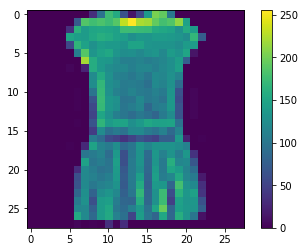

In [11]:
plt.figure()
plt.imshow(train_images[3])
plt.colorbar()
plt.grid(False)

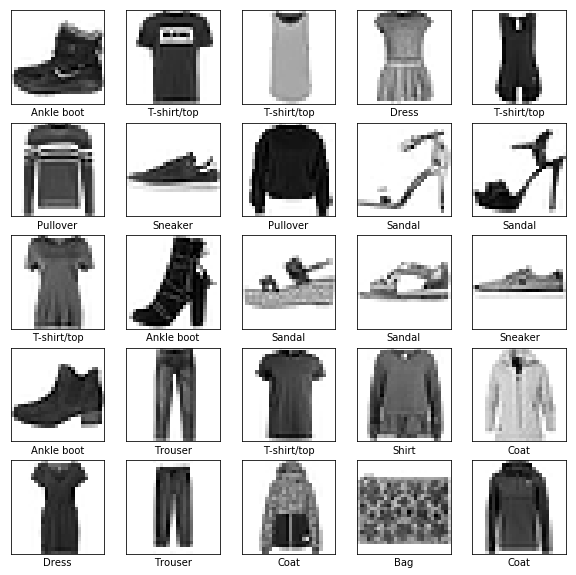

In [12]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

In [4]:
# Figure out the dimensions and shapes of the problem
m_train = len(train_images)
m_test = len(test_images)
num_px = train_images.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ")")
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))

Number of training examples: m_train = 60000
Number of testing examples: m_test = 10000
Height/Width of each image: num_px = 28
Each image is of size: (28, 28)
train_images shape: (60000, 28, 28)
train_labels shape: (60000,)
test_images shape: (10000, 28, 28)
test_labels shape: (10000,)


In [5]:
# 把labels转成one-hot格式
def convert_to_onehot(Y, C):
    
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [6]:
# Reshape the training and test examples
train_images_flatten = train_images.reshape(train_images.shape[0], -1).T
test_images_flatten = test_images.reshape(test_images.shape[0], -1).T

train_labels_onehot = convert_to_onehot(train_labels, 10)
test_labels_onehot = convert_to_onehot(test_labels, 10)

print ("train_images_flatten shape: " + str(train_images_flatten.shape))
print ("train_labels_onehot shape: " + str(train_labels_onehot.shape))
print ("test_images_flatten shape: " + str(test_images_flatten.shape))
print ("test_labels_onehot shape: " + str(test_labels_onehot.shape))

train_images_flatten shape: (784, 60000)
train_labels_onehot shape: (10, 60000)
test_images_flatten shape: (784, 10000)
test_labels_onehot shape: (10, 10000)


In [7]:
# 对数据进行标准化处理
train_set_x = train_images_flatten / 255.0
test_set_x = test_images_flatten / 255.0

### 3. 编写模型相关部分

模型架构及参数选择：
1. 模型框架：input layer — hidden layer (128 units, relu） — output layer(10 units, softmax)
2. 激活函数：relu和softmax
3. 参数初始化方式：随机初始化
4. 损失函数：softmax交叉熵
5. 优化算法：梯度下降

### (1) 定义激活函数

In [8]:
def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache

* 注意:exp(z)容易造成数值上溢，这个问题要处理！
* 可以证明softmax(z) = soft(z+c),其中c为常数，即softmax对input加减一个常数项具有不变性。因此，我们在处理这个问题的时候把z-max(z)

In [9]:
def softmax(Z):
    """
    softmax activation
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of softmax(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    Z_shift = Z - np.max(Z, axis = 0)
    A = np.exp(Z_shift)/ np.sum(np.exp(Z_shift), axis=0)
    
    cache = Z_shift
    
    return A, cache

### (2) 参数初始化

In [10]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x) * 0.01   # weight matrix随机初始化
    b1 = np.zeros((n_h, 1))                 # bias vector零初始化
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters    

### (3) Forward propagation module

The linear forward module (vectorized over all the examples) computes the following equations:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$$

where $A^{[0]} = X$. 

In [11]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    Z = np.dot(W, A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

 Implement the forward propagation of the *LINEAR->ACTIVATION* layer. Mathematical relation is: $A^{[l]} = g(Z^{[l]}) = g(W^{[l]}A^{[l-1]} +b^{[l]})$ where the activation "g" can be softmax() or relu().

In [12]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "softmax" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "softmax":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)
      
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

### (4) Cost Function

In [13]:
def compute_cost(AL, Y):
    """
    Arguments:
    AL -- probability matrix corresponding to your label predictions, shape (classes, number of examples)
    Y -- true "label" matrix, shape (classes, number of examples)

    Returns:
    cost -- softmax cross-entropy cost
    """
    m = Y.shape[1]
    cost = -(np.sum(Y * np.log(AL))) / float(m)
    #cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    return cost

### (5) Backward propagation module

In [14]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ, A_prev.T) / float(m)
    db = np.sum(dZ, axis=1, keepdims=True) / float(m)
    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [20]:
def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    Z = cache
    dZ = np.array(dA, copy=True)  # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [15]:
def softmax_backward(Y, cache):
    """
    合并求导dL/dZ = （dL/dA） * （dA/dZ）

    Arguments:
    Y -- true "label" matrix, shape (classes, number of examples)
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    Z = cache  #注意cache中的Z实际是Z_shift
    
    s = np.exp(Z)/ np.sum(np.exp(Z), axis=0)
    dZ = s - Y
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [16]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for hidden layer or Y for outputlayer!!!
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
 
    elif activation == "softmax":
        dZ = softmax_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

### （6）参数更新

In [17]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(1,L+1):
        parameters['W'+str(l)] -= learning_rate * grads['dW'+str(l)]
        parameters['b'+str(l)] -= learning_rate * grads['db'+str(l)]
    
    return parameters

### 4. 模型整合及有效性检测

In [18]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.1, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label", of shape (classes, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SOFTMAX. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, W1, b1, activation='relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation='softmax')

        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(Y, cache2, activation='softmax')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation='relu')
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [40]:
train_x = train_set_x[:,0:10000]
train_y = train_labels_onehot[:,0:10000]

Cost after iteration 0: 2.300682930678009
Cost after iteration 100: 0.8947419940958851
Cost after iteration 200: 0.7210431986278137
Cost after iteration 300: 0.6200976623616054
Cost after iteration 400: 0.556696247811917
Cost after iteration 500: 0.5190547745807741
Cost after iteration 600: 0.4931844740333001
Cost after iteration 700: 0.4654653335667683
Cost after iteration 800: 0.4478352055777419
Cost after iteration 900: 0.4320776644083264


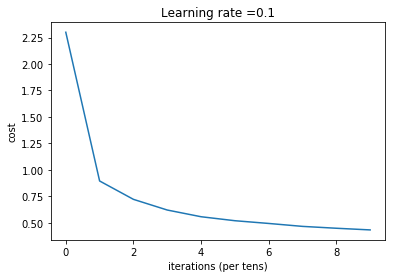

In [41]:
parameters = two_layer_model(train_x, train_y, layers_dims = (784, 128, 10), num_iterations = 1000, print_cost=True)

In [37]:
def predict_labels(X, y, parameters):
    """
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    predict_label -- predictions for the given dataset X
    """
    m = X.shape[1]
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Forward propagation
    A1, _ = linear_activation_forward(X, W1, b1, activation='relu')
    probs, _ = linear_activation_forward(A1, W2, b2, activation='softmax')
    
    # convert probas to 0-9 predictions
    predict_label = np.argmax(probs, axis=0)
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((predict_label == y)/float(m))))
        
    return predict_label

In [42]:
prediction = predict_labels(test_set_x, test_labels, parameters)

Accuracy: 0.8132000000000001
